# SSRL BL1-5 batch integration

A notebook for data reduction from BL1-5 raw data using PyFAI.

Installation instructions for PyFAI [here](https://pyfai.readthedocs.io/en/master/operations/index.html#detailed-installation-procedure). Install in a virtual environment or a conda environment.

PyFAI also has a GUI mode that can be run from the terminal (`> pyFAI-calib2`), which is useful for preparing calibrations and masks.

In [44]:
# Make the necessary imports
import pyFAI
import pyFAI.test.utilstest
import fabio
from pyFAI.gui import jupyter
from pyFAI.gui.jupyter.calib import Calibration

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import tqdm

import os
import glob
import shutil
import re

print(f"PyFAI version {pyFAI.version}")

PyFAI version 0.21.3


Set the known parameters for the experiment. Detectors and calibrants are stored in python objects. PyFAI has a number of detectors built in such as the 1M and 100k used at Bl1-5.

In [45]:
# Set wavelength in meters
wavelength = 0.826565e-10 # Equivalent to 15 keV

# Create detector and calibrant objects for SAXS
pilatus1M = pyFAI.detector_factory("Pilatus1M")
AgBh = pyFAI.calibrant.CALIBRANT_FACTORY("AgBh")
AgBh.wavelength = wavelength

# Create detector and calibrant objects for WAXS
pilatus100k = pyFAI.detector_factory("Pilatus100k")
LaB6 = pyFAI.calibrant.CALIBRANT_FACTORY("LaB6")
LaB6.wavelength = wavelength

# Additional calibrant to use aluminum windows as calibrant
Al_cal = pyFAI.calibrant.CALIBRANT_FACTORY("Al")
Al_cal.wavelength = wavelength

# saxs_path = "December92022/AgBe/agbe30_120922-125943.raw"
# waxs_path = "December82022/M8__LaB6_20221208_T20.0_ctr0_dx0.000000_dy0.00/WAXS/b_tassone_M8__LaB6_20221208_T20.0_ctr0_dx0.000000_dy0.00_scan1_0000.raw"

# # load the file
# saxs = np.fromfile(saxs_path, dtype=np.int32).reshape(1043, 981)
# waxs = np.fromfile(waxs_path, dtype=np.int32).reshape(195, 487)

Load a mask file for the SAXS detector.

The mask can be prepared manually and saved using the GUI.

(run `> pyFAI-calib2` from the terminal)

<AxesSubplot: >

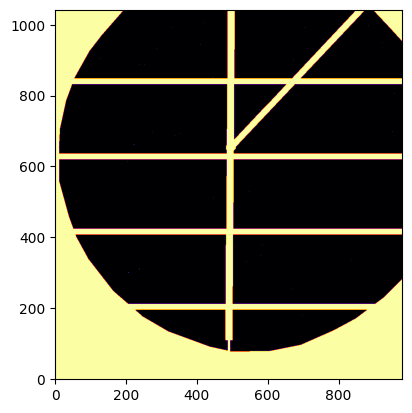

In [46]:
# Load a *.edf file as a pyfai mask
mask = "/Users/yuewu/Desktop/8091E/BL15_1M_gcarbon_mask_3.edf"
mask = fabio.open(mask).data
jupyter.display(mask) # display the mask

PyFAI uses 'azimuthal integrator' objects which reduce raw scattering frames. Integrator objects are created using a `.poni` file which contains the integration parameters.

Calibration files can be prepared and saved as a *.poni file using the GUI by e.g. picking rings on the calibrant frame.

In [47]:
# Create the integrators for SAXS and WAXS using manually prepared poni files
ai_saxs = pyFAI.load("AgBh_1M_calib_GUI.poni")
ai_waxs = pyFAI.load("m33_Al_20C_outer_rings.poni")

## Integration
Now we have imported our calibration information, we can integrate the data.

To batch integrate the data, parse the folder structure.

Note: For experiment 8091E, detector was moved after LaB6 calibration. Al cell windows are used as a calibrant instead. There are two sets of Al rings arising from the two cell windows. The outer (higher q) set of rings were used to prepare the calibration file.

Normalization:
* The `integrate1d(... normalization_factor=...)` argument divides output by the provided factor.
* (Subtract ion chamber dark)
* Normalize for incident flux - spec value `mon`
* Normalize by transmission - average spec values `I0+I1`

Averaging:
* For each condition set, 12 images are taken - 6 WAXS and 6 SAXS. Each at 3 positions with 2 collections.
* Visualisation showed SAXS varied a lot over positions, so positions were not averaged.
* Plotting script is used to find useable data (some positions lose scattering due to sample movement)

This could be broken into functions if needed.

In [25]:
# Set root folder - "." is the parent data folder
root = "."

# Macros contain 'M<number of macro>' in their name, we use this to find the relevant folders
# Set a list of macros to integrate based on reading folder/file prefixes
macro_list = ['M33', 'M35', 'M36', 'M37', 'M38'] #M34 mislabelled as M33, corrected at later stage

# Store reduced files in the 'integrated' folder. If it does not exist, create it. Else delete and create
if not os.path.exists('integrated'):
    os.makedirs('integrated')
else:
    shutil.rmtree('integrated')
    os.makedirs('integrated')


# Find data folders by generating list of subfolders containing a search string
# (Here all data folders contain 'December')
searchstring = 'December'
subfolders = [f.path for f in os.scandir(root) if f.is_dir() if searchstring in f.path]

# Some inconsistent prefixes (typo during macro preparation?): either 'b_tassone_' and 'one_'
# Create a regex expression that removes '...one_' from filenames
regex = re.compile(r'(?<=one_)')

# Loop through each macro and perform batch integration
for macro in macro_list:
    
    # Create an output subfolder for each macro
    if not os.path.exists(f'integrated/{macro}'):
        os.makedirs(f'integrated/{macro}')

    # Search for subfolders containing the macro heading
    for i in subfolders:
        macro_folders = [f.path for f in os.scandir(i) if f.is_dir() if macro in f.path]

        # SAXS integration
        for j in tqdm.tqdm(macro_folders):
            # Read SPEC csv file containing metadata for normalization
            for file in glob.glob(os.path.join(j, '*.csv')):
                df = pd.read_csv(file)

            # Here are the csv column names for reference:
            # df[df.columns[3]][0] # i0
            # df[df.columns[4]] # i1
            # df[df.columns[5]] # mon

            # Look through each raw file in the SAXS folder, integrate and normalise
            for index, file in enumerate(sorted(glob.glob(os.path.join(j, 'SAXS', '*.raw')))):

                # The .raw files are just a list of 32-bit integers so we reshape them
                data = np.fromfile(file, dtype=np.int32).reshape(1043, 981)
                
                # set normalization factors (rescale by 10e6 otherwise values round to 0)
                # Incident (mon) takes range 2M-3M
                mon_factor = float(df[df.columns[5]][index])/10e6
                # Transmission i0/i1 takes range 1M-2M
                i_factor = (float(df[df.columns[3]][index])+float(df[df.columns[4]][index]))/10e6

                # Generate appropriate filename for saving
                # Get filename only from path
                file = os.path.basename(file)
                # Split filename at first occurence of match to remove '...one_'
                file = regex.split(file, 1)[1]

                # integrate and save SAXS into macro folders
                ai_saxs.integrate1d(
                    data, 
                    1000, 
                    filename=f"integrated/{macro}/{file[:-4]}_SAXS.dat", 
                    normalization_factor=mon_factor*i_factor,
                    mask=mask)

            for index, file in enumerate(sorted(glob.glob(os.path.join(j, 'WAXS', '*.raw')))):
                data = np.fromfile(file, dtype=np.int32).reshape(195, 487)
                file = os.path.basename(file)
                file = regex.split(file, 1)[1]

                # set normalization factors
                # Incident (mon) takes range 2M-3M
                mon_factor = float(df[df.columns[5]][index])/10e6

                ai_waxs.integrate1d(
                    data, 
                    1000, 
                    filename=f"integrated/{macro}/{file[:-4]}_WAXS.dat",
                    normalization_factor=mon_factor)                

0it [00:00, ?it/s]
100%|██████████| 275/275 [00:16<00:00, 16.76it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 104/104 [00:06<00:00, 17.17it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 143/143 [00:08<00:00, 16.84it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 260/260 [00:15<00:00, 17.04it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 260/260 [00:15<00:00, 16.98it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


# Plotting

See pyfai_batch_plotting.ipynb for plotting of the integrated files.